In [1]:
### Like V4, but with *even lower* cuts on error to mask more pixels

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
import astropy
from astropy.io import ascii
from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
import scipy as sp
import csv

%matplotlib inline

In [2]:
### Importing the .fits file with all stars outside SNRs
stellar_data_dir2 = '/uufs/chpc.utah.edu/common/home/sdss11/dr16/apogee/spectro/aspcap/r12/l33/'
select_stars = '/uufs/astro.utah.edu/common/uuastro/astrougrad/u1068803/SNR_Thesis/Stars_Outside_SNRs_V2.fits'
star_hdus = fits.open(select_stars)
star_list = star_hdus[1].data
star_headers = star_hdus[1].header
star_hdus.close()

sl = star_list.copy()

# SNR_star_headers

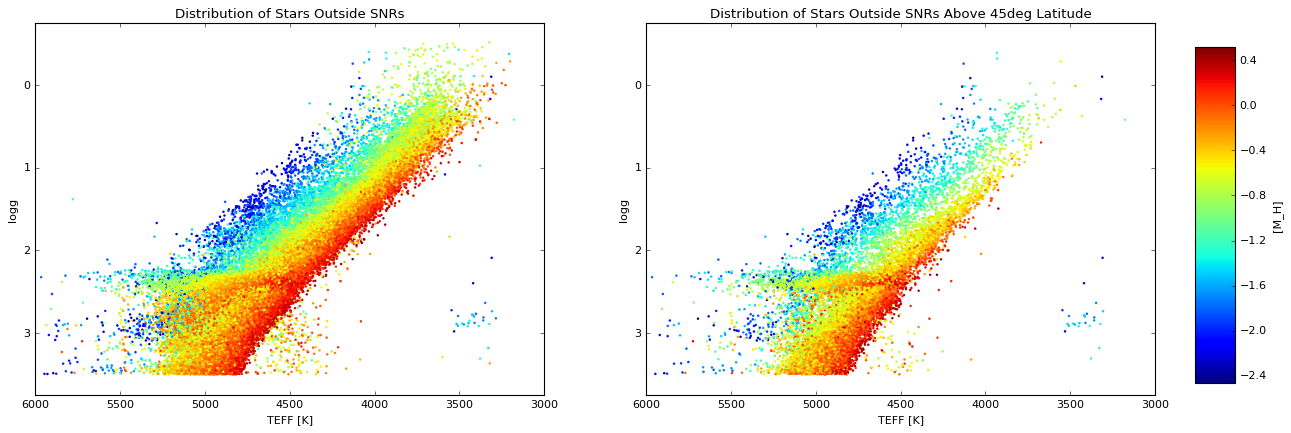

In [3]:
### Plotting HR diagram of stars
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(20)
plt.figure(figsize=(10,6))
f.axes[0].scatter(sl['TEFF'], sl['LOGG'], c=sl['M_H'], s=5, linewidth=0)
# cbar = plt.colorbar()
# cbar.set_label('[M_H]')
f.axes[0].set_xlabel('TEFF [K]')
f.axes[0].set_ylabel('logg')
f.axes[0].set_title('Distribution of Stars Outside SNRs')
f.axes[0].set_ylim(3.75, -0.75)
f.axes[0].set_xlim(6000, 3000)
# plt.savefig('HRD_StarsOutsideSNRs_woLat.png')
# plt.show()
# plt.clf()


#  f.axes[b].set_xlim(16010, 16120)
#                 f.axes[b].set_ylabel('Residual')
#                 f.axes[b].set_ylim(0.8, 1.6)
            
### Making a coordinate array of all stars
from astropy.coordinates import SkyCoord
import astropy.units as u
sl_coords = SkyCoord(sl['RA'], sl['DEC'], unit=(u.degree, u.degree))
sl_coords_gal_lat = sl_coords.galactic.b

### Applying a latitude cut selecting stars above 45deg
latitudecut = abs(sl_coords_gal_lat.deg) >= 45

### Plotting HR diagram of stars post-latitude cut
im = f.axes[1].scatter(sl['TEFF'][latitudecut], sl['LOGG'][latitudecut], c=sl['M_H'][latitudecut], s=5, linewidth=0)
f.axes[1].set_xlabel('TEFF [K]')
f.axes[1].set_ylabel('logg')
f.axes[1].set_title('Distribution of Stars Outside SNRs Above 45deg Latitude')
f.axes[1].set_ylim(3.75, -0.75)
f.axes[1].set_xlim(6000, 3000)

### Adding a colorbar for metallicity
f.subplots_adjust(right=0.825)
cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
f.colorbar(im, cax=cbar_ax, label='[M_H]')

f.savefig('HRD_subplots.png', bbox_inches='tight')

In [4]:
### Defining bins of TEFF, LOGG, and M_H
delta_teff = 200
delta_logg = 0.2
delta_mh = 0.2
teff_array = np.arange(3200, 6000, delta_teff)
logg_array = np.arange(0, 3.5, delta_logg)
mh_array = np.arange(-2.5, 0.8, delta_mh)
# TEFF_bins = np.arange(3600, 4800, 200)
# LOGG_bins = np.arange(0, 3.5, 0.2)
# MH_bins = np.arange(-2.5, 0.8, 0.2)

In [5]:
### Defining an empty array to sort stars into
sorted_stars = [[[[] for m in range(len(mh_array))] for g in range(len(logg_array))] for t in range(len(teff_array))]

### Making a coordinate array of all stars
from astropy.coordinates import SkyCoord
import astropy.units as u
sl_coords = SkyCoord(sl['RA'], sl['DEC'], unit=(u.degree, u.degree))
sl_coords_gal_lat = sl_coords.galactic.b

### For each star in starlist, sort into paramter bins
for i_teff, this_teff in enumerate(teff_array):
    for i_logg, this_logg in enumerate(logg_array):
        for i_mh, this_mh in enumerate(mh_array):
            ### If star is w/i this particular bin, add a 'True' to an indexed list
            ind = (abs(sl['TEFF'] - this_teff) <= delta_teff/2)\
            & (abs(sl['LOGG'] - this_logg) <= delta_logg/2)\
            & (abs(sl['M_H'] - this_mh) <= delta_mh/2)\
            & (abs(sl_coords_gal_lat.deg) >= 45) ### This line controls the galactic latitude cut
            ### Obtain the star_list indices of all 'True's' and add them to bin in sorted list
            true = [i for i,x in enumerate(ind) if x]
            sorted_stars[i_teff][i_logg][i_mh] = true
    print('Current Temperature Index:', i_teff) ### Progress check

('Current Temperature Index:', 0)
('Current Temperature Index:', 1)
('Current Temperature Index:', 2)
('Current Temperature Index:', 3)
('Current Temperature Index:', 4)
('Current Temperature Index:', 5)
('Current Temperature Index:', 6)
('Current Temperature Index:', 7)
('Current Temperature Index:', 8)
('Current Temperature Index:', 9)
('Current Temperature Index:', 10)
('Current Temperature Index:', 11)
('Current Temperature Index:', 12)
('Current Temperature Index:', 13)


In [6]:
### Import sample APOGEE spectrum to get master wavelength array
### Define the master stellar data directory
stellar_data_dir = '/uufs/chpc.utah.edu/common/home/sdss06/apogeework/'+\
                   'apogee/spectro/aspcap/t9/l31c/'
### File name format for APOGEE stars
test_star = fits.open(stellar_data_dir + sl['TELESCOPE'][0].strip()  + '/' + \
                      sl['FIELD'][0].strip() + '/' + 'aspcapStar-t9-' + \
                      sl['APOGEE_ID'][0].strip() + '.fits')
### Building the master wavelength array
wavelength_start = test_star[1].header['CRVAL1']
wavelength_logdisp = test_star[1].header['CDELT1']
num_wavelength = test_star[1].header['NAXIS1']
wavelength = 10**(wavelength_start + 
                  np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp))
test_star.close()

### Convert wavelength to masked array
wavelength = np.ma.array(wavelength)

In [32]:
### Creating a general header with parameter range information
hdr = fits.Header()
hdr['TEFF_min'] = np.min(teff_array)
hdr['TEFF_max'] = np.max(teff_array)
hdr['TEFF_spacing'] = delta_teff
hdr['LOGG_min'] = np.min(logg_array)
hdr['LOGG_max'] = np.max(logg_array)
hdr['LOGG_spacing'] = delta_logg
hdr['M_H_min'] = np.min(mh_array)
hdr['M_H_max'] = np.max(mh_array)
hdr['M_H_spacing'] = delta_mh
bin_primary = fits.PrimaryHDU(header=hdr)
### Creating an HDU with the above header that we can add imageHDUs to
hdu1 = fits.HDUList([bin_primary])

### For each bin, create a median residual spectrum
import os
for t in range(len(teff_array)):
    for g in range(len(logg_array)):
        for m in range(len(mh_array)):
            bin_residuals = []
            bin_star_count = 0
                                ### [t][g][m]
            for i in range(len(sorted_stars[t][g][m])): # For each star in this particular bin,
                ### Define path to individual star file
                temp_path = stellar_data_dir2 + sl['TELESCOPE'][i].strip()  + '/' + \
                                          sl['FIELD'][i].strip() + '/' + 'aspcapStar-r12-' + \
                                          sl['APOGEE_ID'][i].strip() + '.fits'
                ### If there is a file at that path (sometimes there isn't?),
                if os.path.isfile(temp_path):
                    temp_star = fits.open(temp_path)
                    ### Obtain the APOGEE spectrum
                    temp_spec = np.array(temp_star[1].data)
                    ### Obtain the error for that spectrum
                    temp_err = np.array(temp_star[2].data)
                    ### Obtain the ASPCAP fit spectrum
                    temp_fit = np.array(temp_star[3].data)
                    temp_star.close()
                    ### Take the residuals (observed/fit)
                    stellar_resid = (temp_spec / temp_fit)
                    ### Masking high-error pixels (i.e. > 7), NaNs and zeroes
                    for this_wavelength in range(len(stellar_resid)):
                        if temp_err[this_wavelength] > 1:
                            stellar_resid[this_wavelength] = np.nan
                        if stellar_resid[this_wavelength] <= 0:
                            stellar_resid[this_wavelength] = np.nan
                    ### Temporarily store the stellar residual
                    bin_residuals.append(stellar_resid)
                    bin_star_count = bin_star_count + 1
            ### For each bin, take the median of all stellar residual spectra
            bin_median_residual = np.nanmedian(bin_residuals, axis=0)
            ### Find stdev at each pixel across all stellar residuals
            bin_stdev_residual = np.nanstd(bin_residuals, axis=0)
            ### Creating a temporary header with relevant bin information
            temp_hdr = fits.Header()
            temp_hdr['bin_starcount'] = bin_star_count
            temp_hdr['bin_TEFF_min'] = teff_array[t]
            temp_hdr['bin_TEFF_max'] = teff_array[t]+delta_teff
            temp_hdr['TEFF_spacing'] = delta_teff
            temp_hdr['bin_LOGG_min'] = logg_array[g]
            temp_hdr['bin_LOGG_max'] = logg_array[g]+delta_logg
            temp_hdr['LOGG_spacing'] = delta_logg
            temp_hdr['bin_M_H_min'] = mh_array[m]
            temp_hdr['bin_M_H_max'] = mh_array[m]+delta_mh
            temp_hdr['M_H_spacing'] = delta_mh
            ### Store bin resid & stdev as imageHDU and add it to the master HDU
            image_hdu = fits.ImageHDU([bin_median_residual,bin_stdev_residual], header=temp_hdr)
            hdu1.append(image_hdu)
#             ### Plot median stellar residual spectrum with stdev error bars on each pixel
#             plt.figure(figsize=(16, 8))
#             plt.xlabel('Wavelength ($\AA$)')
#             plt.ylabel('Bin Median Residual Spectrum')
#             plt.title('Median Residual Spectrum\n'+
#                       'TEFF '+str(teff_array[t])+' LOGG '+str(logg_array[g])+' M_H '+str(mh_array[m]))
#             plt.errorbar(x=wavelength, y=bin_median_residual, yerr=bin_stdev_residual, marker='None', linewidth=0.5, zorder=1)
#             ### Adding a horizontal bar at unity for clarity
#             plt.hlines(y=1, xmin=np.min(wavelength), xmax=np.max(wavelength), linestyles = '--', colors='k', zorder=0)
#             plt.xlim(16010, 16120)
#             plt.ylim(0.9, 1.1)
    print('Current TEFF Index:', t)
hdu1.writeto('Stellar_Masks_V7.fits', overwrite=True)

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide


('Current TEFF Index:', 0)
('Current TEFF Index:', 1)
('Current TEFF Index:', 2)
('Current TEFF Index:', 3)
('Current TEFF Index:', 4)
('Current TEFF Index:', 5)
('Current TEFF Index:', 6)
('Current TEFF Index:', 7)
('Current TEFF Index:', 8)
('Current TEFF Index:', 9)
('Current TEFF Index:', 10)
('Current TEFF Index:', 11)
('Current TEFF Index:', 12)
('Current TEFF Index:', 13)


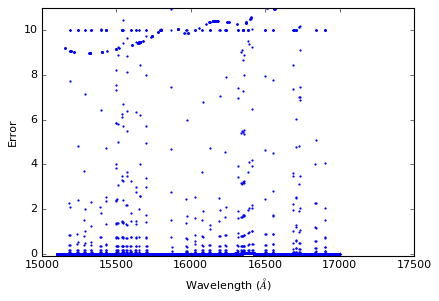

In [31]:
plt.scatter(wavelength, temp_err, s=4, linewidth=0)
plt.ylim(-0.1, 11)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Error')

In [53]:
np.set_printoptions(threshold = np.inf)
stellar_resid


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [68]:
for r in range(len(stellar_resid)):
    if stellar_resid[r] == 0 and np.isnan(stellar_resid[r]) == False:
        print('fuck')
        print(stellar_resid[r])
        stellar_resid[r] = np.nan

In [36]:
### Old Code & Tests Below

In [43]:
x = [1,2,3,4,5,6,7,8,9]
y = [1,1,np.nan,1,1,np.nan,1,np.nan,1]
np.nanmin(y)

1.0

(2, 3600, 2, 0.4, 9, -0.6999999999999984)


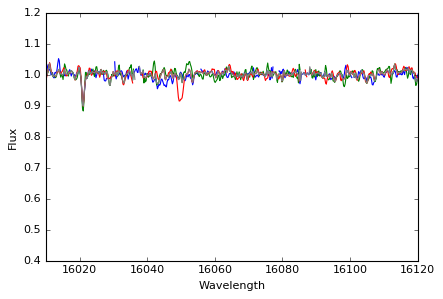

In [17]:
### Creating a general header with parameter range information
hdr = fits.Header()
hdr['TEFF_min'] = np.min(teff_array)
hdr['TEFF_max'] = np.max(teff_array)
hdr['TEFF_spacing'] = delta_teff
hdr['LOGG_min'] = np.min(logg_array)
hdr['LOGG_max'] = np.max(logg_array)
hdr['LOGG_spacing'] = delta_logg
hdr['M_H_min'] = np.min(mh_array)
hdr['M_H_max'] = np.max(mh_array)
hdr['M_H_spacing'] = delta_mh
bin_primary = fits.PrimaryHDU(header=hdr)
### Creating an HDU with the above header that we can add imageHDUs to
hdu1 = fits.HDUList([bin_primary])

### For each bin, create a median residual spectrum
import os
for t in range(len([2])):
    for g in range(len([2])):
        for m in range(len([2])):
            t, g, m = 2, 2, 9
            bin_residuals = []
            bin_star_count = 0
                                ### [t][g][m]
            for i in range(len(sorted_stars[t][g][m])): # For each star in this particular bin,
                ### Define path to individual star file
                temp_path = stellar_data_dir2 + sl['TELESCOPE'][i].strip()  + '/' + \
                                          sl['FIELD'][i].strip() + '/' + 'aspcapStar-r12-' + \
                                          sl['APOGEE_ID'][i].strip() + '.fits'
                ### If there is a file at that path (sometimes there isn't?),
                if os.path.isfile(temp_path):
                    temp_star = fits.open(temp_path)
                    ### Obtain the APOGEE spectrum
                    temp_spec = np.ma.array(temp_star[1].data)
                    ### Obtain the error for that spectrum
                    temp_err = np.ma.array(temp_star[2].data)
                    ### Obtain the ASPCAP fit spectrum
                    temp_fit = np.ma.array(temp_star[3].data)
                    temp_star.close()
                    ### Take the residuals (observed/fit)
                    stellar_resid = (temp_spec / temp_fit)
                    ### Masking high-error pixels (i.e. > 50)
                    resid_mask = np.ma.masked_where(temp_err > 8, stellar_resid)
                    resid_mask = np.ma.masked_where(np.isnan(resid_mask), resid_mask)
                    resid_mask = np.ma.masked_where(resid_mask == 0, resid_mask)
                    ### Temporarily store the stellar residual
                    bin_residuals.append(resid_mask)
                    bin_star_count = bin_star_count + 1
                    if np.all(np.isnan(resid_mask)) == False:
                        plt.plot(wavelength, resid_mask)
#                         plt.plot(wavelength, temp_err, c='gray')
            ### For each bin, take the median of all stellar residual spectra
            bin_median_residual = np.ma.median(bin_residuals, axis=0)
            bin_median_residual = np.ma.masked_where(bin_median_residual == 0, bin_median_residual)
            #######################################################
            # bin_median_residual = np.nanmedian(bin_residuals, axis=0)
            if np.all(np.isnan(bin_median_residual)) == False:
                print(t, teff_array[t], g, logg_array[g], m, mh_array[m])
                plt.ylabel('Flux')
                plt.xlabel('Wavelength')
                plt.plot(wavelength, bin_median_residual, color='gray')
                plt.xlim(16010, 16120)
#                plt.xlim(16030, 16040)
                plt.show()
                plt.clf()
#             ### Find stdev at each pixel across all stellar residuals
#             bin_stdev_residual = np.nanstd(bin_residuals, axis=0)
#             ### Creating a temporary header with relevant bin information
#             temp_hdr = fits.Header()
#             temp_hdr['bin_starcount'] = bin_star_count
#             temp_hdr['bin_TEFF_min'] = teff_array[t]
#             temp_hdr['bin_TEFF_max'] = teff_array[t]+delta_teff
#             temp_hdr['TEFF_spacing'] = delta_teff
#             temp_hdr['bin_LOGG_min'] = logg_array[g]
#             temp_hdr['bin_LOGG_max'] = logg_array[g]+delta_logg
#             temp_hdr['LOGG_spacing'] = delta_logg
#             temp_hdr['bin_M_H_min'] = mh_array[m]
#             temp_hdr['bin_M_H_max'] = mh_array[m]+delta_mh
#             temp_hdr['M_H_spacing'] = delta_mh
#             ### Store bin resid & stdev as imageHDU and add it to the master HDU
#             image_hdu = fits.ImageHDU([bin_median_residual,bin_stdev_residual], header=temp_hdr)
#             hdu1.append(image_hdu)
# #             ### Plot median stellar residual spectrum with stdev error bars on each pixel
# #             plt.figure(figsize=(16, 8))
# #             plt.xlabel('Wavelength ($\AA$)')
# #             plt.ylabel('Bin Median Residual Spectrum')
# #             plt.title('Median Residual Spectrum\n'+
# #                       'TEFF '+str(teff_array[t])+' LOGG '+str(logg_array[g])+' M_H '+str(mh_array[m]))
# #             plt.errorbar(x=wavelength, y=bin_median_residual, yerr=bin_stdev_residual, marker='None', linewidth=0.5, zorder=1)
# #             ### Adding a horizontal bar at unity for clarity
# #             plt.hlines(y=1, xmin=np.min(wavelength), xmax=np.max(wavelength), linestyles = '--', colors='k', zorder=0)
# #             plt.xlim(16010, 16120)
# #             plt.ylim(0.9, 1.1)
#     print('Current TEFF Index:', t)
# hdu1.writeto('Stellar_Masks_V3.fits', overwrite=True)

(0, 15)

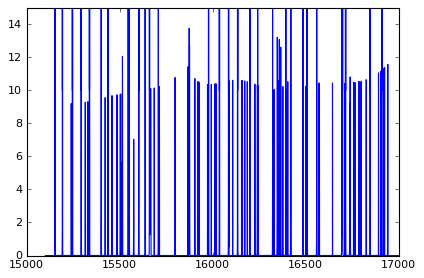

In [16]:
plt.plot(wavelength, temp_err)
plt.ylim(0, 15)

In [ ]:
### Creating a general header with parameter range information
hdr = fits.Header()
hdr['TEFF_min'] = np.min(teff_array)
hdr['TEFF_max'] = np.max(teff_array)
hdr['TEFF_spacing'] = delta_teff
hdr['LOGG_min'] = np.min(logg_array)
hdr['LOGG_max'] = np.max(logg_array)
hdr['LOGG_spacing'] = delta_logg
hdr['M_H_min'] = np.min(mh_array)
hdr['M_H_max'] = np.max(mh_array)
hdr['M_H_spacing'] = delta_mh
bin_primary = fits.PrimaryHDU(header=hdr)
### Creating an HDU with the above header that we can add imageHDUs to
hdu1 = fits.HDUList([bin_primary])

### For each bin, create a median residual spectrum
import os
for t in range(len([2])):
    for g in range(len([2])):
        for m in range(len([2])):
            t, g, m = 2, 2, 9
            bin_residuals = []
            bin_star_count = 0
                                ### [t][g][m]
            for i in range(len(sorted_stars[t][g][m])): # For each star in this particular bin,
                ### Define path to individual star file
                temp_path = stellar_data_dir2 + sl['TELESCOPE'][i].strip()  + '/' + \
                                          sl['FIELD'][i].strip() + '/' + 'aspcapStar-r12-' + \
                                          sl['APOGEE_ID'][i].strip() + '.fits'
                ### If there is a file at that path (sometimes there isn't?),
                if os.path.isfile(temp_path):
                    temp_star = fits.open(temp_path)
                    ### Obtain the APOGEE spectrum
                    temp_spec = np.ma.array(temp_star[1].data)
                    ### Obtain the error for that spectrum
                    temp_err = np.ma.array(temp_star[2].data)
                    ### Obtain the ASPCAP fit spectrum
                    temp_fit = np.ma.array(temp_star[3].data)
                    temp_star.close()
                    ### Take the residuals (observed/fit)
                    stellar_resid = (temp_spec / temp_fit)
                    ### Masking high-error pixels (i.e. > 50)
                    resid_mask = np.ma.masked_where(temp_err > 25, stellar_resid)
                    resid_mask = np.ma.masked_where(np.isnan(resid_mask), resid_mask)
                    resid_mask = np.ma.masked_where(resid_mask == 0, resid_mask)
                    ### Temporarily store the stellar residual
                    bin_residuals.append(resid_mask)
                    bin_star_count = bin_star_count + 1
                    if np.all(np.isnan(resid_mask)) == False:
                        plt.plot(wavelength, resid_mask)
#                         plt.plot(wavelength, temp_err, c='gray')
            ### For each bin, take the median of all stellar residual spectra
            bin_median_residual = np.ma.median(bin_residuals, axis=0)
            bin_median_residual = np.ma.masked_where(bin_median_residual == 0, bin_median_residual)
            #######################################################
            # bin_median_residual = np.nanmedian(bin_residuals, axis=0)
            if np.all(np.isnan(bin_median_residual)) == False:
                print(t, teff_array[t], g, logg_array[g], m, mh_array[m])
                plt.ylabel('Flux')
                plt.xlabel('Wavelength')
                plt.plot(wavelength, bin_median_residual, color='gray')
                plt.xlim(16010, 16120)
#                plt.xlim(16030, 16040)
                plt.show()
                plt.clf()
#             ### Find stdev at each pixel across all stellar residuals
#             bin_stdev_residual = np.nanstd(bin_residuals, axis=0)
#             ### Creating a temporary header with relevant bin information
#             temp_hdr = fits.Header()
#             temp_hdr['bin_starcount'] = bin_star_count
#             temp_hdr['bin_TEFF_min'] = teff_array[t]
#             temp_hdr['bin_TEFF_max'] = teff_array[t]+delta_teff
#             temp_hdr['TEFF_spacing'] = delta_teff
#             temp_hdr['bin_LOGG_min'] = logg_array[g]
#             temp_hdr['bin_LOGG_max'] = logg_array[g]+delta_logg
#             temp_hdr['LOGG_spacing'] = delta_logg
#             temp_hdr['bin_M_H_min'] = mh_array[m]
#             temp_hdr['bin_M_H_max'] = mh_array[m]+delta_mh
#             temp_hdr['M_H_spacing'] = delta_mh
#             ### Store bin resid & stdev as imageHDU and add it to the master HDU
#             image_hdu = fits.ImageHDU([bin_median_residual,bin_stdev_residual], header=temp_hdr)
#             hdu1.append(image_hdu)
# #             ### Plot median stellar residual spectrum with stdev error bars on each pixel
# #             plt.figure(figsize=(16, 8))
# #             plt.xlabel('Wavelength ($\AA$)')
# #             plt.ylabel('Bin Median Residual Spectrum')
# #             plt.title('Median Residual Spectrum\n'+
# #                       'TEFF '+str(teff_array[t])+' LOGG '+str(logg_array[g])+' M_H '+str(mh_array[m]))
# #             plt.errorbar(x=wavelength, y=bin_median_residual, yerr=bin_stdev_residual, marker='None', linewidth=0.5, zorder=1)
# #             ### Adding a horizontal bar at unity for clarity
# #             plt.hlines(y=1, xmin=np.min(wavelength), xmax=np.max(wavelength), linestyles = '--', colors='k', zorder=0)
# #             plt.xlim(16010, 16120)
# #             plt.ylim(0.9, 1.1)
#     print('Current TEFF Index:', t)
# hdu1.writeto('Stellar_Masks_V3.fits', overwrite=True)

In [193]:
numpy.set_printoptions(threshold=10)

In [200]:
bin_median_residual

masked_array(data=[0., 0., 0., ..., 0., 0., 0.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [169]:
len(bin_residuals)

3

In [180]:
np.ma.median()

TypeError: masked_where() takes at least 2 arguments (1 given)

In [182]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
np.ma.median(bin_residuals, axis=0)

masked_array(data=[0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.     

In [188]:
np.ma.median(bin_residuals, axis=0)

masked_array(data=[0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.        ,
                   0.        , 0.        , 0.        , 0.     

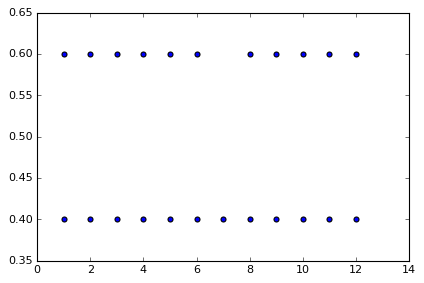

In [184]:
x = np.ma.array([2,2,2,2,2,4,4,2,2,2,4,2])
y = np.ma.array([2,2,2,2,4,2,4,2,2,2,2,2])
z = 3
w = np.ma.array([1,2,3,4,5,6,7,8,9,10,11,12])

xmask = np.ma.masked_where(x > z, x)
wmask_x = np.ma.masked_where(x > z, w)
ymask = np.ma.masked_where(y > z, y)
wmask_y = np.ma.masked_where(y > z, w)

a = np.ma.array([5,5,5,5,5,5,5,5,5,5,5,5])
b = np.median([x, y])/a
c_med = np.ma.array((xmask, ymask))
c_med2 = np.ma.median(c_med, axis=0)
c = c_med2/a

plt.scatter(w, b)
plt.scatter(w, c+.2)
# from operator import and_
# c = np.ma.array(np.median([xmask.data, ymask.data]), mask=list(map(and_, xmask.mask, ymask.mask)))

In [186]:
c_med2

masked_array(data=[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, --, 2.0, 2.0, 2.0, 2.0,
                   2.0],
             mask=[False, False, False, False, False, False,  True, False,
                   False, False, False, False],
       fill_value=1e+20)

(0, 2)

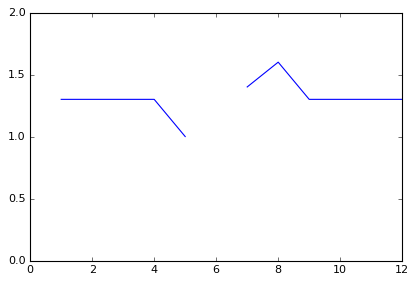

In [165]:
plt.plot(w, c)
plt.ylim(0,2)